# Тест по метрике linearized likes

Метод *linearized likes* для увеличения чувствительности теста:
* Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
* Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
* После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Если тест на метрике *linearized likes* «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).

**Задачи:**
1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats
import numpy as np

## Загружаем данные

In [2]:
# Загружаем датасет
# Подключаемся к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220420'
}
# Запрос к БД
# Данные о количестве пользователей, просмотров, лайков и сообщений в приложении за неделю
q = '''
    SELECT 
        exp_group, user_id, 
        countIf(action='like') as likes,
        countIf(action='view') as views,
        countIf(action='like')/countIf(action='view') as ctr
    FROM
        simulator_20220420.feed_actions
    WHERE 
        (toDate(time) BETWEEN '2022-04-04' AND '2022-04-10') 
        AND (exp_group IN (0, 1, 2, 3))
    GROUP BY
        user_id, exp_group
'''
# Сохраним результат запроса в pandas df
df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125
...,...,...,...,...,...
40074,0,27030,8,39,0.205128
40075,3,122758,30,198,0.151515
40076,1,132567,45,296,0.152027
40077,3,122190,19,65,0.292308


## 1. Тест между группами 0 и 3

In [4]:
# Сохраним необходимые данные в новый df
df_03 = df.query('exp_group==0 or exp_group==3').copy()

In [5]:
# 0 - контрольная группа; 3 - экспериментальная группа
df_03.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
2,3,123580,13,48,0.270833
6,0,30319,21,110,0.190909
8,3,118359,7,38,0.184211
10,0,7626,14,39,0.358974


In [6]:
# Рассчитаем общий CTR в контрольной группе
ctr_control_03 = df_03[df_03['exp_group']==0].likes.sum() / df_03[df_03['exp_group']==0].views.sum()
# ctr_control_03

In [7]:
# Посчитаем в обеих группах поюзерную метрику 
linearized_likes_0 = df_03[df_03['exp_group']==0].likes - ctr_control_03 * df_03[df_03['exp_group']==0].views
linearized_likes_3 = df_03[df_03['exp_group']==3].likes - ctr_control_03 * df_03[df_03['exp_group']==3].views
# Добавим linearized likes в df
df_03.loc[df_03['exp_group']==0, 'linearized_likes'] = linearized_likes_0
df_03.loc[df_03['exp_group']==3, 'linearized_likes'] = linearized_likes_3

In [8]:
df_03.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
2,3,123580,13,48,0.270833,3.004666
6,0,30319,21,110,0.190909,-1.905973
8,3,118359,7,38,0.184211,-0.912973
10,0,7626,14,39,0.358974,5.878791


### 1.1. Тесты

**H0 - значимых различий метрик в группах нет;  
H1 - значимые различия между группами есть.**

#### t-тест Стьюдента

In [9]:
# Сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(linearized_likes_0, 
                linearized_likes_3,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [10]:
# Сравним t-тестом отличия в группах по метрике CTR
stats.ttest_ind(df[df['exp_group']==0].ctr, 
                df[df['exp_group']==3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

#### Тест Манна-Уитни

In [11]:
# Сравним тестом Манна-Уитни отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘e𝑠
stats.mannwhitneyu(linearized_likes_0, 
                   linearized_likes_3)

MannwhitneyuResult(statistic=43338326.0, pvalue=1.1517315029786597e-63)

In [12]:
# Сравним тестом Манна-Уитни отличия в группах по метрике CTR
stats.mannwhitneyu(df[df['exp_group']==0].ctr, 
                   df[df['exp_group']==3].ctr)

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

### 1.2. Визуализация

<AxesSubplot:xlabel='ctr', ylabel='Count'>

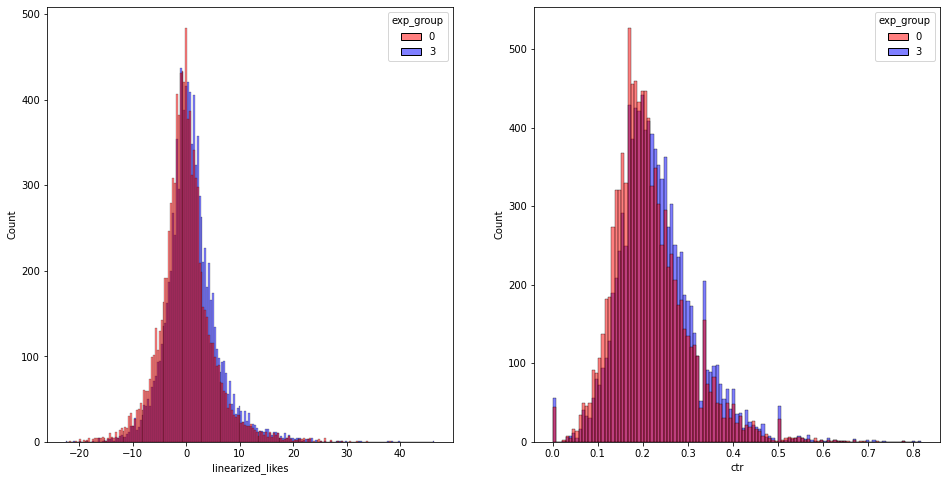

In [13]:
# Посмотрим на распределение 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 и CTR в 2-х группах
f, axs = plt.subplots(1,2, figsize=(16,8))
sns.histplot(df_03, x='linearized_likes', hue='exp_group', palette=['r','b'], ax=axs[0])
sns.histplot(df_03, x='ctr', hue='exp_group', palette=['r','b'], ax=axs[1])

### 1.3. Анализ

* **Оба теста** по обеим метрикам **показали значимые различия** между контрольной (0) и экспериментальной (3) группами. 
* **p-value** по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 **стало меньше** по сравнению с метрикой CTR.
* Форма распределения метрик примерно одинаковая, но в 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 отсутствуют выбросы по краям.

## 2. Тест между группами 1 и 2

In [14]:
# Сохраним необходимые данные в новый df
df_12 = df.query('exp_group==1 or exp_group==2').copy()

In [15]:
# 1 - контрольная группа; 2 - экспериментальная группа
df_12.head()

,exp_group,user_id,likes,views,ctr
1,1,18392,7,32,0.218750
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125
5,2,24239,40,90,0.444444
7,1,27443,2,29,0.068966


In [16]:
# Рассчитаем общий CTR в контрольной группе (1)
ctr_control_12 = df_12[df_12['exp_group']==1].likes.sum() / df_12[df_12['exp_group']==1].views.sum()
# ctr_control_12

In [17]:
# Посчитаем в обеих группах поюзерную метрику 
linearized_likes_1 = df_12[df_12['exp_group']==1].likes - ctr_control_12 * df_12[df_12['exp_group']==1].views
linearized_likes_2 = df_12[df_12['exp_group']==2].likes - ctr_control_12 * df_12[df_12['exp_group']==2].views
# Добавим linearized likes в df
df_12.loc[df_12['exp_group']==1, 'linearized_likes'] = linearized_likes_1
df_12.loc[df_12['exp_group']==2, 'linearized_likes'] = linearized_likes_2

In [18]:
df_12.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
1,1,18392,7,32,0.218750,0.343142
3,2,131473,14,134,0.104478,-13.875592
4,2,32420,26,128,0.203125,-0.627431
5,2,24239,40,90,0.444444,21.277588
7,1,27443,2,29,0.068966,-4.032777


### 2.1. Тесты

**H0 - значимых различий метрик в группах нет;  
H1 - значимые различия между группами есть.**

#### t-тест Стьюдента

In [19]:
# Сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(linearized_likes_1, 
                linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

In [20]:
# Сравним t-тестом отличия в группах по метрике CTR
stats.ttest_ind(df[df['exp_group']==1].ctr, 
                df[df['exp_group']==2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

* Тест Стьюдента по метрике CTR не позволяет утверждать, что имеются значимые различия (p-value > 0.05) между контрольной и экспериментальной группами. 
* А по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 - наоборот, тест показывает статистически значимые различия.

#### Тест Манна-Уитни

In [21]:
# Сравним тестом Манна-Уитни отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘e𝑠
stats.mannwhitneyu(linearized_likes_1, 
                   linearized_likes_2)

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

In [22]:
# Сравним тестом Манна-Уитни отличия в группах по метрике CTR
stats.mannwhitneyu(df[df['exp_group']==1].ctr, 
                   df[df['exp_group']==2].ctr)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни по обеим метрикам показывает значимые различия между контрольной (1) и экспериментальной (2) группами.

### 2.2. Визуализация

<AxesSubplot:xlabel='ctr', ylabel='Count'>

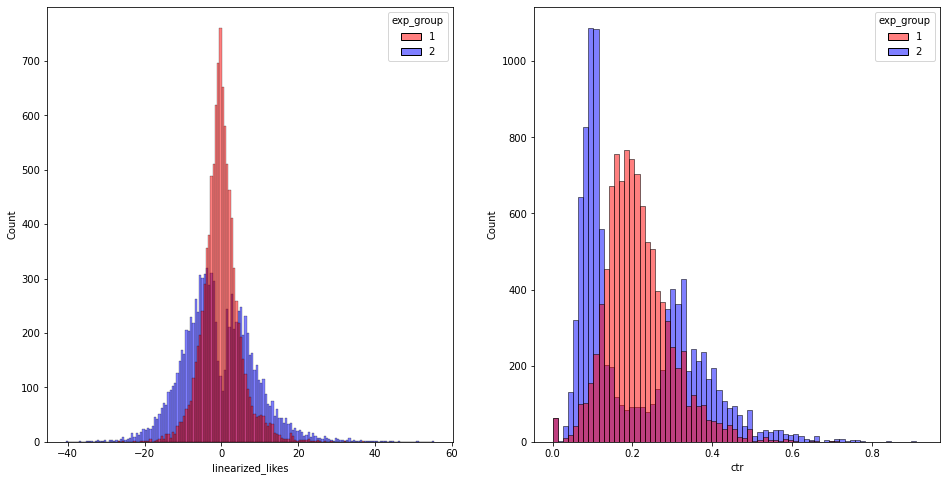

In [23]:
# Посмотрим на распределение 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 и CTR в 2-х группах
f, axs = plt.subplots(1,2, figsize=(16,8))
sns.histplot(df_12, x='linearized_likes', hue='exp_group', palette=['r','b'], ax=axs[0])
sns.histplot(df_12, x='ctr', hue='exp_group', palette=['r','b'], ax=axs[1])

### 2.3. Анализ

* **Тест Стьюдента** по метрике CTR не позволяет утверждать, что имеются значимые различия (p-value > 0.05) между контрольной и экспериментальной группами. А **по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠** - наоборот, **тест показывает статистически значимые различия** (p-value << 0.05).
* **Тест Манна-Уитни** по обеим метрикам показывает **значимые различия** между контрольной (1) и экспериментальной (2) группами. Однако p-value по CTR ниже, чем по 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠.
* **p-value** по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 **стало меньше** по сравнению с метрикой CTR.
* Распределение метрики 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 значительно отличается от распределения CTR. 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 приобрела форму близкую к нормальной, распределение в обеих группах стало уже, практически исчезли выбросы.